In [1]:
%matplotlib inline
from numpy import linalg as LA
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import torch 

np.random.seed(2)

In [2]:
%config InlineBackend.figure_format = 'retina'
plt.style.use('dark_background')

In [3]:
def read_turbine(t_no, sensors = range(3)):
    df = [ pd.read_hdf(DATA_PATH, key = 'Turbine{:02d}/Sensor{:02d}'.format(t_no, j))
        for j in sensors
    ]
    return df[0].index, np.hstack([col.values.astype(float) for col in df])

In [4]:
WIND, ROTOR, POWER = 1, 2, 3
DATA_PATH = "../Data/key_value_scada.h5"

In [5]:
def train_test():
    t_no = 1
    timestamp, X = read_turbine(t_no, sensors = [WIND, ROTOR, POWER])
    X[:, 2] /= 100 # roughly normalize second column
    N, I = X.shape

    X_training = X[4767:12767 , :]
    X_train = X_training[~np.isnan(X_training).any(axis = 1)]

    return X, X_train, timestamp

In [6]:
X, X_train, timestamp = train_test()

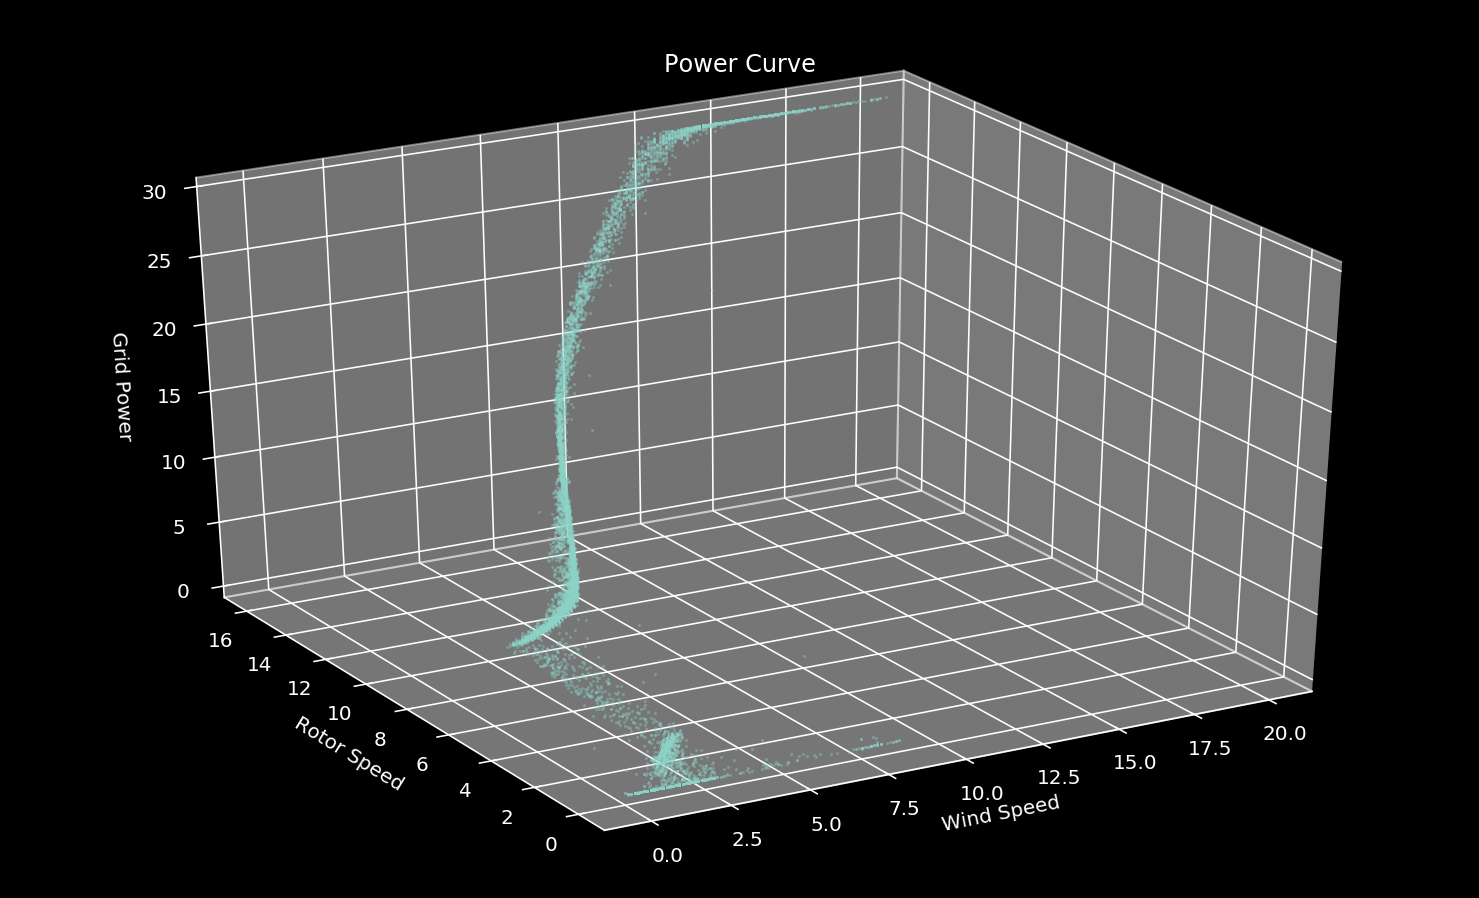

In [7]:
ax = plt.figure(figsize = (13, 8))
ax = plt.axes(projection='3d')

ax.plot3D(X_train[:,0], X_train[:,1], X_train[:,2], '.', alpha=0.4, ms=1)

ax.set_title('Power Curve')
ax.set_xlabel('Wind Speed')
ax.set_ylabel('Rotor Speed')
ax.set_zlabel('Grid Power')
#ax.set_xlabel('Rüzgar Hızı')
#ax.set_ylabel('Döneç Hızı')
#ax.set_zlabel('Üretilen Güç')

ax.view_init(azim=240)
plt.show()

In [8]:
from __future__ import print_function
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
train = X_train[:,0].reshape(len(X_train), 1)
output = X_train[:,1:3]

In [10]:
# Recurrent neural network (many-to-one)
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        #print (out.shape, out[:, -1, :].shape)
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [11]:
# Hyper-parameters
sequence_length = 1
input_size = 1
hidden_size = 256
num_layers = 2
num_classes = 2
batch_size = 1000
num_epochs = 10
learning_rate = 0.01

In [12]:
model = BiLSTM(input_size, hidden_size, num_layers, num_classes).to(device)
print (model)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

BiLSTM(
  (lstm): LSTM(1, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=2, bias=True)
)


In [13]:
for epoch in range(num_epochs):
    for i in range(int((len(X_train)-batch_size)/10)):
        train_ = train[i*10:i*10+batch_size]
        train_ = torch.Tensor(train_)
        train_ = train_.reshape(-1, sequence_length, input_size).to(device)
        
        
        output_ = output[i*10:i*10+batch_size]
        output_ = torch.Tensor(output_)
        #print (output_.shape)
        #output_ = output_.reshape(-1, sequence_length, input_size).to(device)
        # Forward pass
        results_ = model(train_)
        loss = criterion(results_, output_)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, int((len(X_train)-batch_size)/10), loss.item()))

Epoch [1/10], Step [100/700], Loss: 0.5900
Epoch [1/10], Step [200/700], Loss: 0.3138
Epoch [1/10], Step [300/700], Loss: 0.5023
Epoch [1/10], Step [400/700], Loss: 1.6892
Epoch [1/10], Step [500/700], Loss: 0.8722
Epoch [1/10], Step [600/700], Loss: 6.6310
Epoch [1/10], Step [700/700], Loss: 0.5314
Epoch [2/10], Step [100/700], Loss: 0.4823
Epoch [2/10], Step [200/700], Loss: 0.2964
Epoch [2/10], Step [300/700], Loss: 0.4889
Epoch [2/10], Step [400/700], Loss: 1.6867
Epoch [2/10], Step [500/700], Loss: 0.8690
Epoch [2/10], Step [600/700], Loss: 6.3433
Epoch [2/10], Step [700/700], Loss: 0.5056
Epoch [3/10], Step [100/700], Loss: 0.4724
Epoch [3/10], Step [200/700], Loss: 0.2956
Epoch [3/10], Step [300/700], Loss: 0.4895
Epoch [3/10], Step [400/700], Loss: 1.6854
Epoch [3/10], Step [500/700], Loss: 0.8653
Epoch [3/10], Step [600/700], Loss: 6.4453
Epoch [3/10], Step [700/700], Loss: 0.5107
Epoch [4/10], Step [100/700], Loss: 0.4725
Epoch [4/10], Step [200/700], Loss: 0.2936
Epoch [4/10

In [14]:
with torch.no_grad():
    X_ = X[:,0].reshape(len(X), 1)
    Y_ = X[:,1:3]
    test_ = torch.Tensor(X_)
    test_ = test_.reshape(-1, sequence_length, input_size).to(device)
    prediction_ = model(test_)
    
prediction = prediction_.detach().numpy()

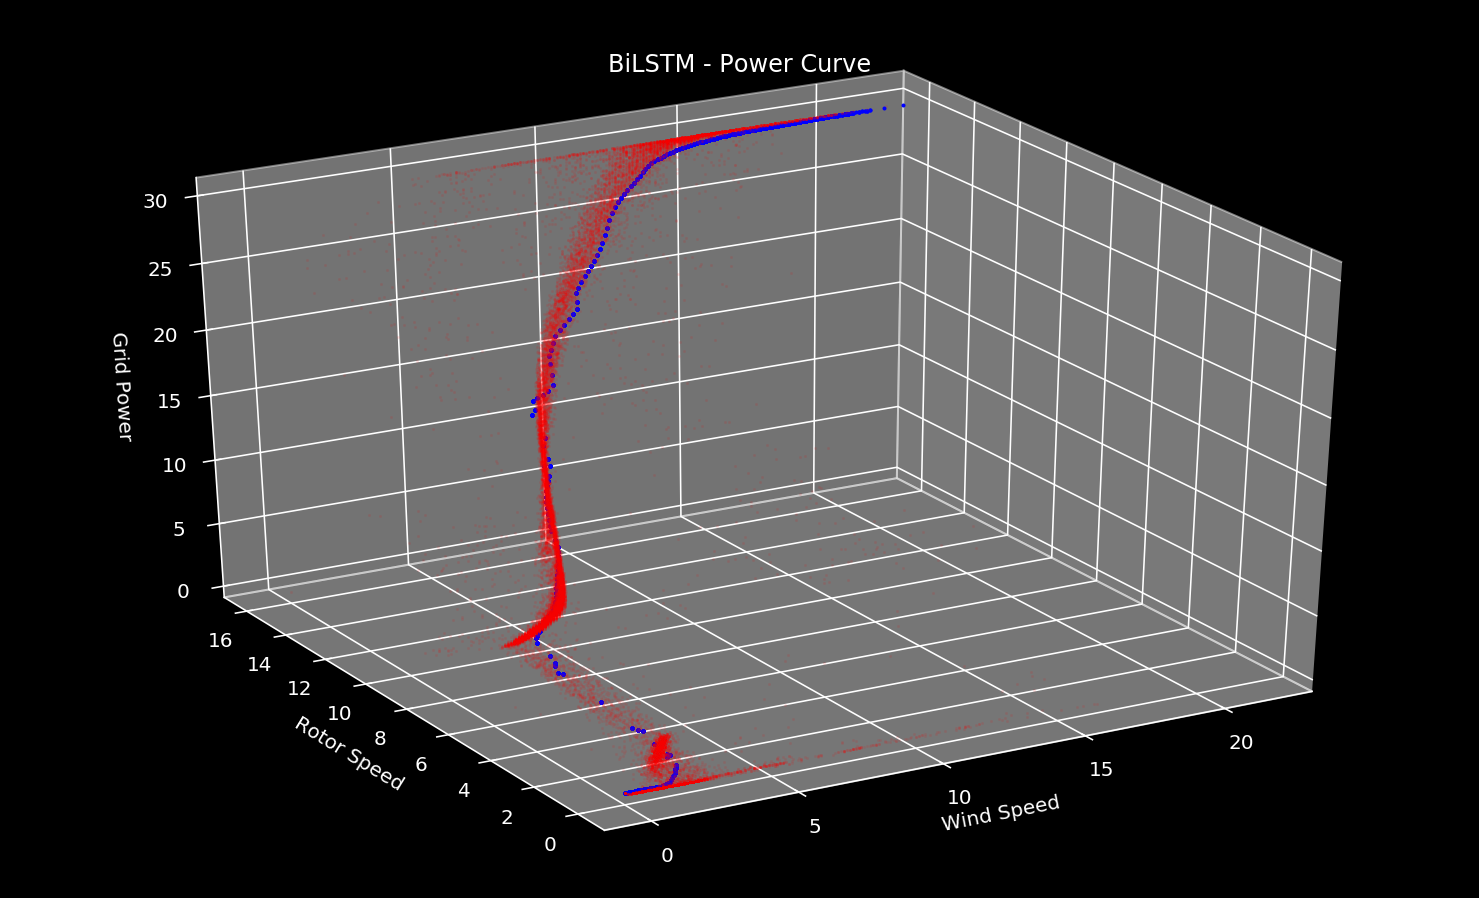

In [15]:
ax = plt.figure(figsize = (13, 8))
ax = plt.axes(projection='3d')

ax.plot3D(X[:,0], prediction[:,0], prediction[:,1], 'b.', alpha=1, ms=2)
ax.plot3D(X[:,0], X[:,1], X[:,2], 'r.', alpha=0.1, ms=1)

ax.set_title('BiLSTM - Power Curve')
ax.set_xlabel('Wind Speed')
ax.set_ylabel('Rotor Speed')
ax.set_zlabel('Grid Power')
#ax.set_xlabel('Rüzgar Hızı')
#ax.set_ylabel('Döneç Hızı')
#ax.set_zlabel('Üretilen Güç')

ax.view_init(azim=240)
plt.show()

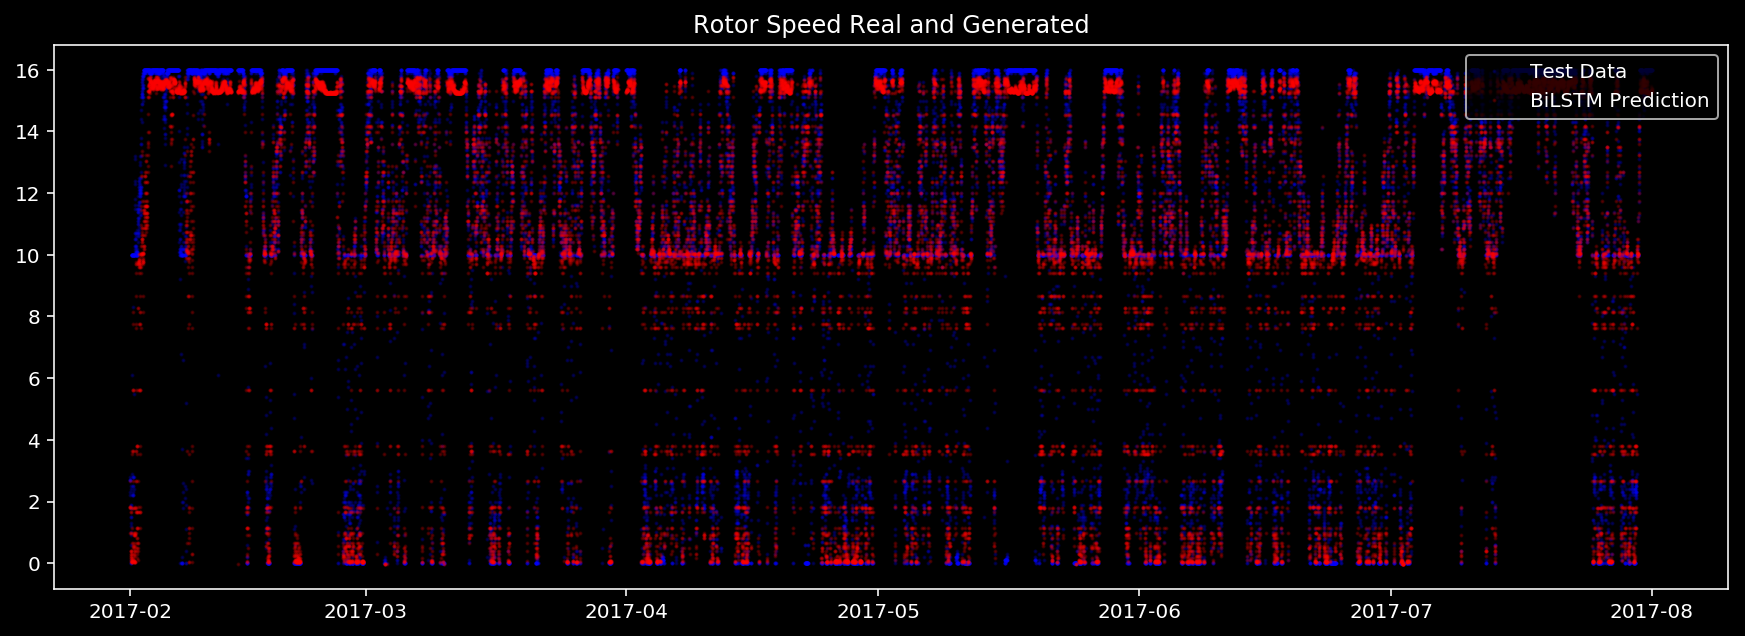

In [16]:
plt.figure(figsize=(15,5))
plt.title("Rotor Speed Real and Generated")
plt.plot(timestamp, X[:,1], 'b.', alpha=0.2, ms = 2, label = 'Test Data')
plt.plot(timestamp, prediction[:,0], 'r.', alpha=0.2, ms = 2, label = 'BiLSTM Prediction')
plt.legend(loc='upper right')
plt.show()

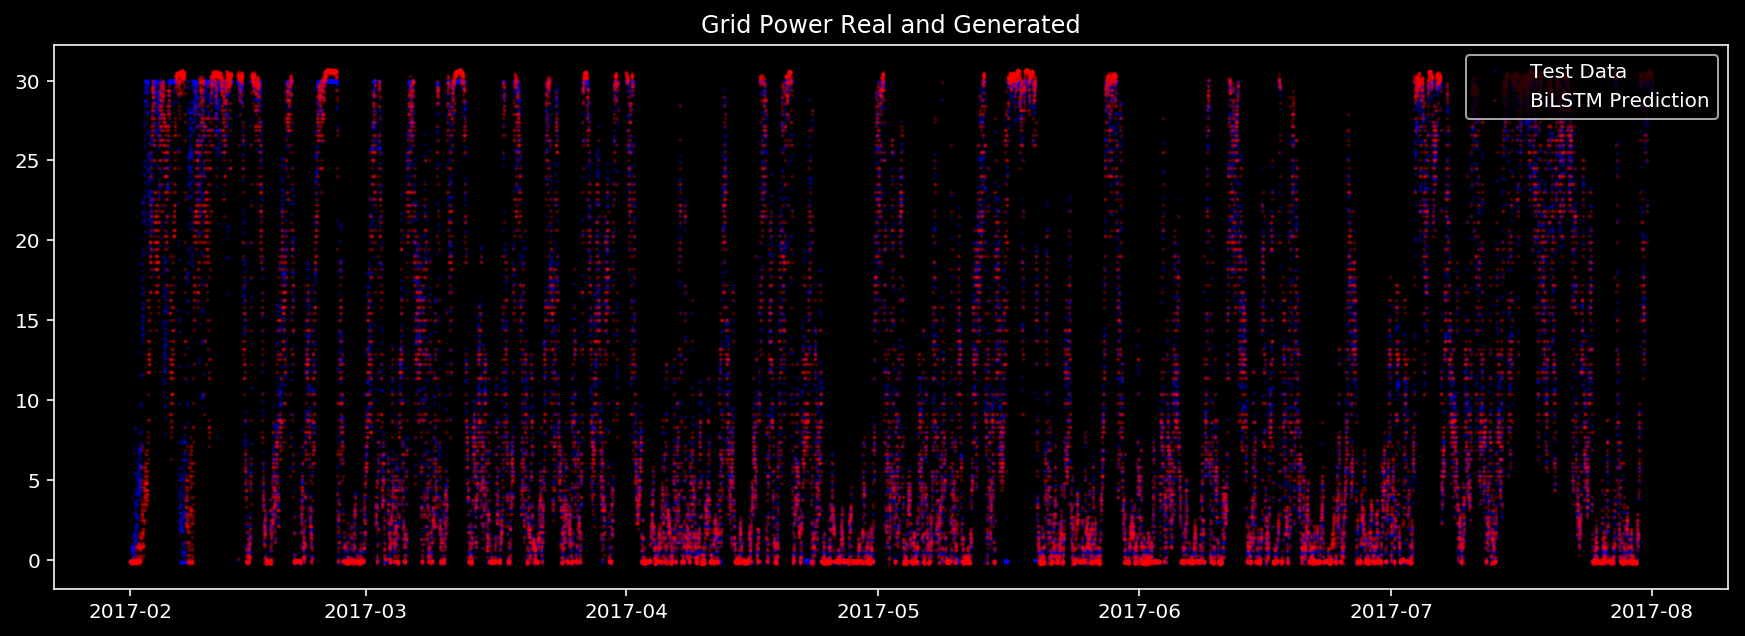

In [17]:
plt.figure(figsize=(15,5))
plt.title("Grid Power Real and Generated")
plt.plot(timestamp, X[:,2], 'b.', alpha=0.2, ms = 2, label = 'Test Data')
plt.plot(timestamp, prediction[:,1], 'r.', alpha=0.2, ms = 2, label = 'BiLSTM Prediction')
plt.legend(loc='upper right')
plt.show()

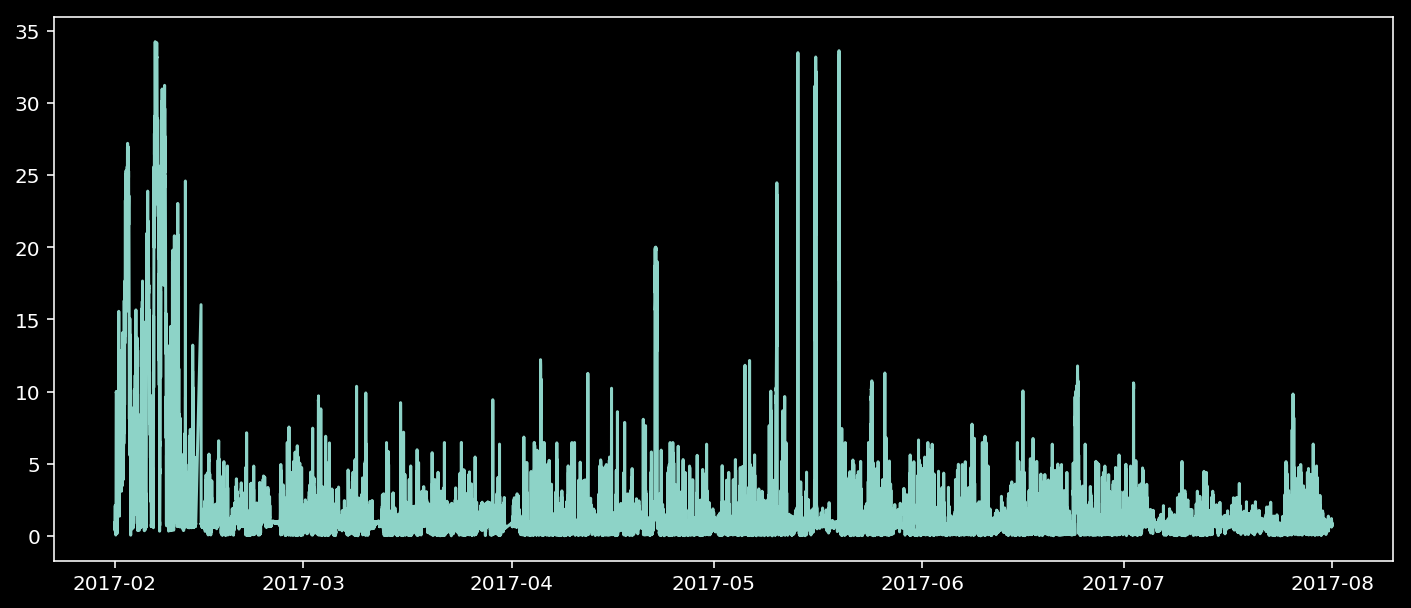

In [18]:
E = X[:,1:3] - prediction
E_norm = np.linalg.norm(E, axis = 1)
plt.figure(figsize=(12,5))
plt.plot(timestamp, E_norm)
plt.show()

In [19]:
smoothing_coefficient = 0.99
average = np.zeros(len(E_norm))
for i in range(len(E_norm)):
        if (i == 0):
            average[i] = E_norm[i]
        else:
            average[i] = average[i - 1]*smoothing_coefficient + E_norm[i]*(1 - smoothing_coefficient)

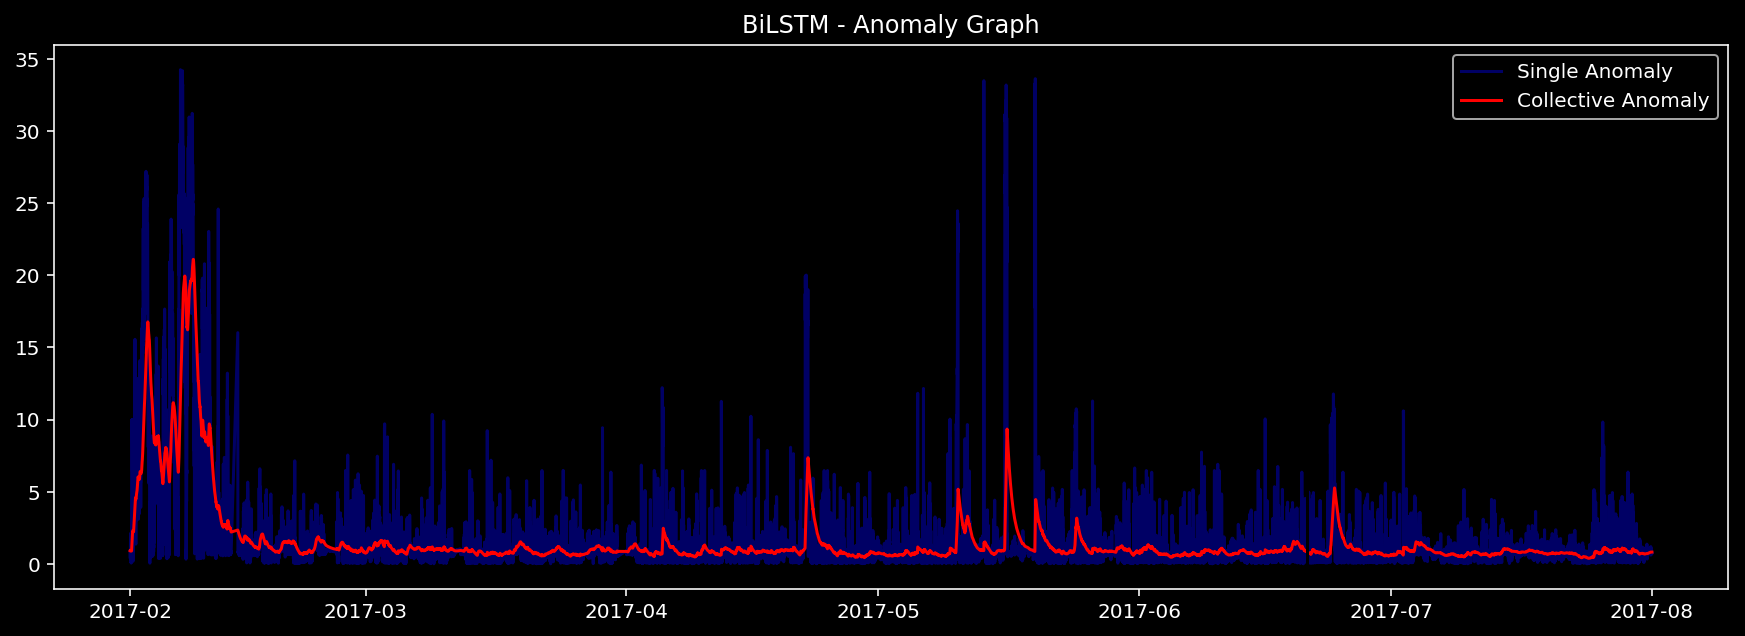

In [20]:
plt.figure(figsize=(15,5))
plt.title("BiLSTM - Anomaly Graph")
plt.plot(timestamp, E_norm,'b', alpha=0.4, ms = 2, label='Single Anomaly')
plt.plot(timestamp, average, 'r', alpha=1, ms = 2, label='Collective Anomaly')
plt.axvline('2017-06-21', color='black')
plt.legend(loc='upper right')
plt.show()